In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string

# Download stopwords
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [60]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Datasets/Quora duplicate Questions dataset/train.csv')
# isduplicate = 1 if question1 and question2 have essentially the same meaning, and 0 otherwise

df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [61]:
df.columns

Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate'], dtype='object')

In [62]:
df.shape

(404290, 6)

In [65]:
def preprocess_text(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stopwords.words('english')]
    return ' '.join(tokens)

df['question1'] = df['question1'].apply(lambda x: preprocess_text(str(x)))
df['question2'] = df['question2'].apply(lambda x: preprocess_text(str(x)))

In [66]:
# Combine the questions into one column for vectorization
questions = pd.Series(df['question1'].tolist() + df['question2'].tolist()).astype(str)

# Fit TF-IDF Vectorizer
tfidf = TfidfVectorizer(max_features=5000)
tfidf.fit(questions)

# Transform questions
question1_tfidf = tfidf.transform(df['question1'].values)
question2_tfidf = tfidf.transform(df['question2'].values)

In [67]:
from scipy.sparse import hstack

X = hstack([
    question1_tfidf,
    question2_tfidf,
    np.abs(question1_tfidf - question2_tfidf)
])

y = df['is_duplicate'].values


In [68]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [69]:
model = LogisticRegression()
model.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

Accuracy:  0.7846224244972668
              precision    recall  f1-score   support

           0       0.81      0.86      0.83     50803
           1       0.73      0.66      0.70     30055

    accuracy                           0.78     80858
   macro avg       0.77      0.76      0.76     80858
weighted avg       0.78      0.78      0.78     80858



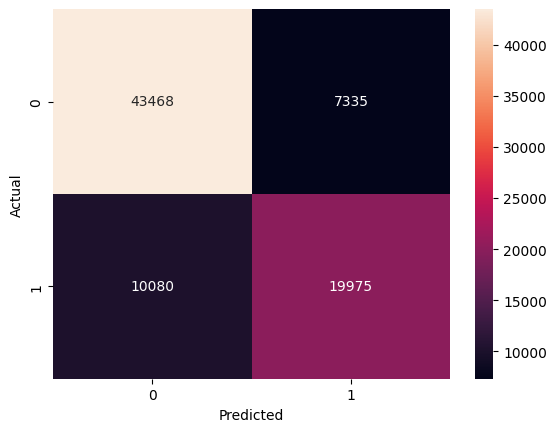

In [70]:
y_pred = model.predict(X_test)

print("Accuracy: ", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [71]:
def preprocess_text_for_prediction(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    tokens = word_tokenize(text)
    # Remove stopwords
    tokens = [word for word in tokens if word not in stopwords.words('english')]
    return ' '.join(tokens)

def predict_duplicate(question1, question2):
    question1 = preprocess_text_for_prediction(question1)
    question2 = preprocess_text_for_prediction(question2)

    q1_tfidf = tfidf.transform([question1])
    q2_tfidf = tfidf.transform([question2])

    features = hstack([
        q1_tfidf,
        q2_tfidf,
        np.abs(q1_tfidf - q2_tfidf)
    ])

    prediction = model.predict(features)
    return prediction[0]

question1 = "How do I cook pasta?"
question2 = "What is the best way to cook pasta?"
print("Are these questions duplicates?: ", predict_duplicate(question1, question2))

Are these questions duplicates?:  0
